In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import bluesquare_data_pipelines.access as blsq

%matplotlib inline

/anaconda3/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [11]:
%%capture
pdss = blsq.dhis_instance("local_pdss")

pdss_elements = ["Radio ou téléphone mobile DE LA STRUCTURE",
                "Transmission du rapport SNIS et un ",
                "Au moins cinq problèmes de santé prioritaires sont suivis chaque trimestre",
                "Plan de management montre les tarifs négociés entre FOSA",
                "Le plan de management montre la planification ",
                "Le comité pour les des indigents se réunit mensuellement",
                "La clôture existe, peut être fermée la nuit",
                "Poubelle avec couvercle accessible aux clients",
                "Au moins deux latrines",
                "Sol sans fissures avec un seul trou",
                "Récemment nettoyé sans matière fécale visible.",
                "Éclairage fonctionnel",
                "Fosse d’élimination des déchets minimum 2 mètres",
                "L'eau courante (robinet ou distributeur d'eau)",
                "Matelas lavable ou couvert",
                "L’évaluateur vérifie les patients consultés dans le registre pour les trois derniers dimanches",
                "Dans le registre choisir les 5 derniers cas de paludisme SIMPLE",
                "Thermomètre disponible et fonctionnel",
                "Au moins un membre du personnel formé en planification familiale",
                "Les DIU sont disponibles",
                "Au moins 20 implants disponibles",
                "Au moins 20 tests non expirés",
                 "Oxytocine",
                 "Mébendazole",
                 "Amoxycilline",
                 "SRO sachet",
                 "Zinc cés",
                 "Plaquettes de contraceptifs oraux",
                 "Depo-provera inj",
                 "Aspirateur plongé dans un désinfectant non irritant",
                 "Disponibilité d'au moins 5 paires de gants stériles",
                 "Lits en bon état avec matelas couverts de toile cirée",
                 "Température comprise entre",
                 "BCG, Penta, la poliomyélite, la fièvre jaune",
                 "Au moins 30 Seringues autobloquantes",
                 "Pèse-bébé étalonné à zéro",
                 "La CPN réalisée par une infirmière A2 ",
                 "Chaque patient TBC pulmonaire- BAAR a une personne (parraine) attachée à lui",
                 "Chaque patient TBC pulmonaire a une adresse",
                 "Disponibilité des médicaments antituberculeux",
                 "Tous les cas de TB ont subi un test de VIH",
                 "Disponibilité d’un Kit de violence sexuelle"]

pdss_ids = pdss.dataelement.uid[pdss.dataelement.name.str.contains('|'.join(pdss_elements))]

In [43]:
%%capture
pdss_extract = pdss.get_data(pdss_ids, pdss.organisationunit.uid) ;

In [44]:
pdss_extract.dataelementname = pdss_extract.dataelementname.str.lower()
pdss_extract = pdss_extract[(pdss_extract.quarterly < "2019Q1") & (pdss_extract.quarterly >= "2017Q1")]

In [45]:
pdss_extract = pdss_extract.set_index(["uidlevel2", "uidlevel3","uidorgunit","enddate"])
pdss_extract.value = pdss_extract.value.astype(float).astype(int)

pdss_extract = pdss_extract[~ pdss_extract.dataelementname.str.contains("- score")]

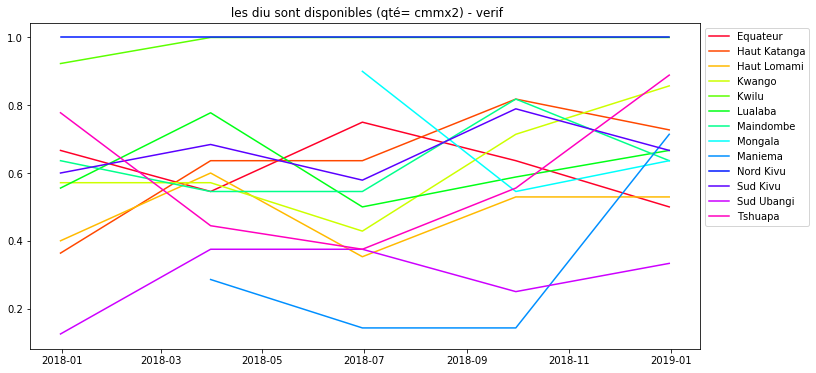

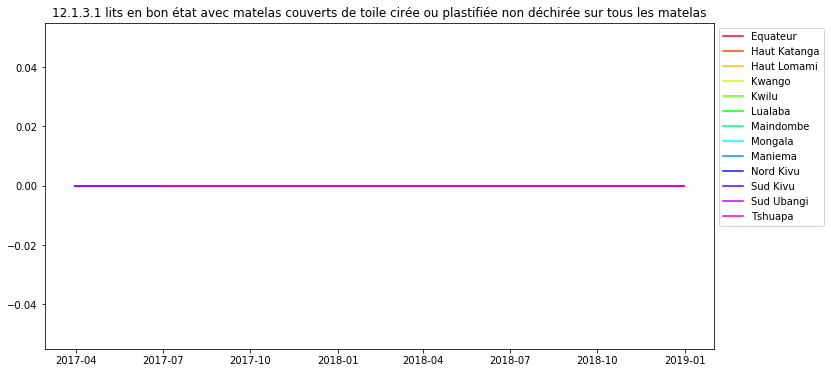

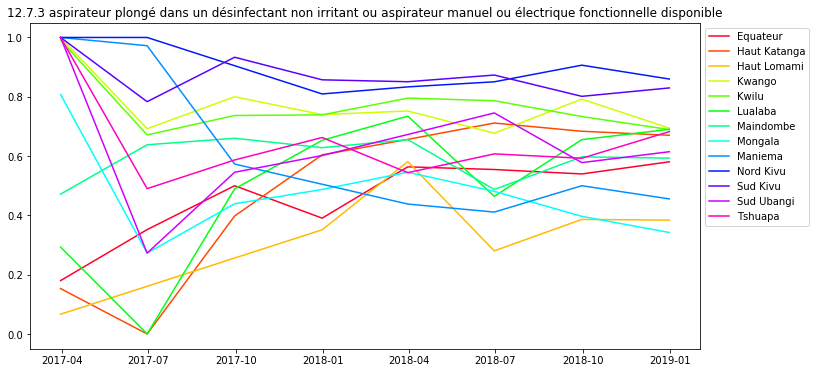

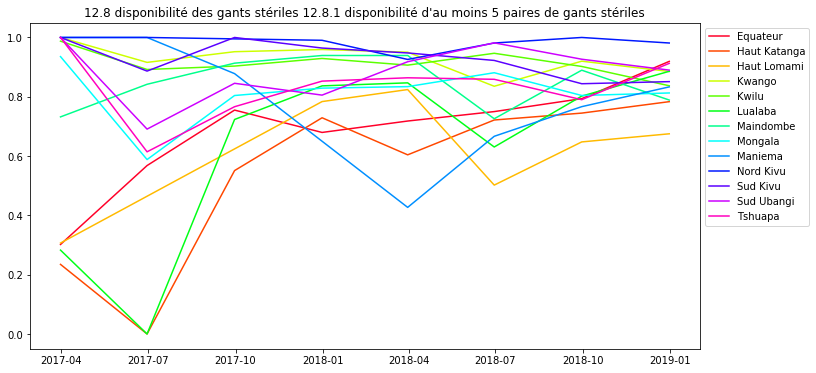

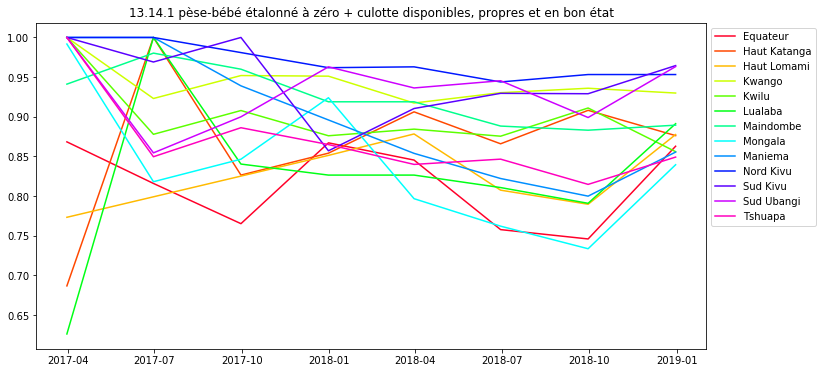

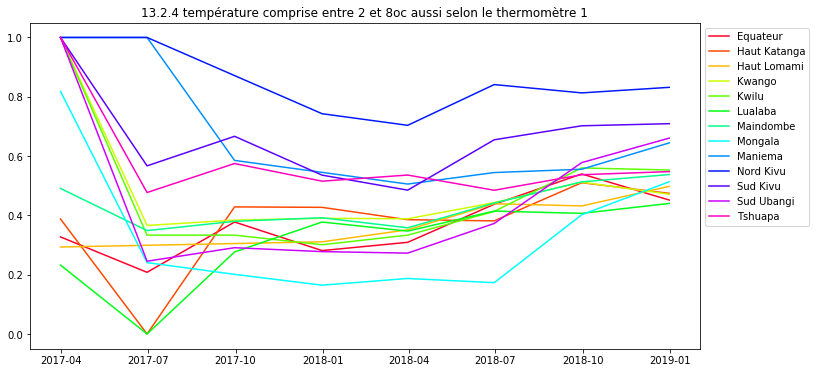

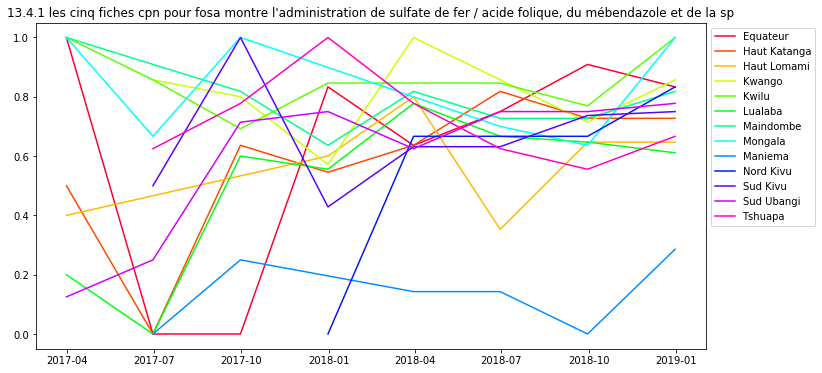

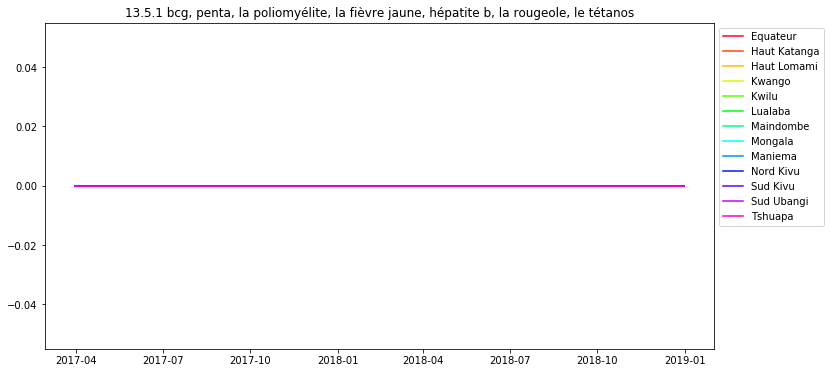

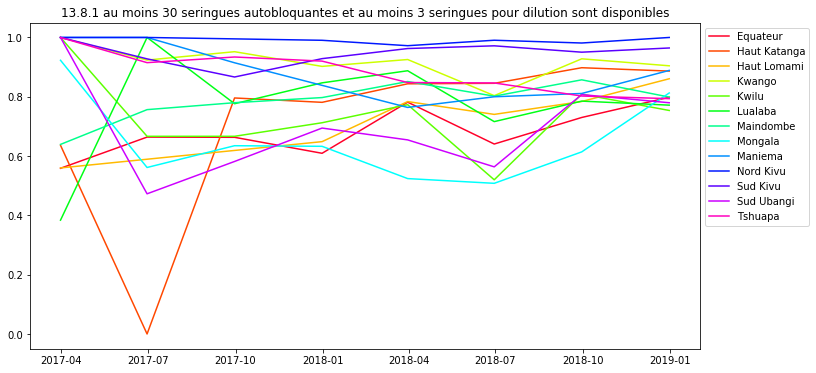

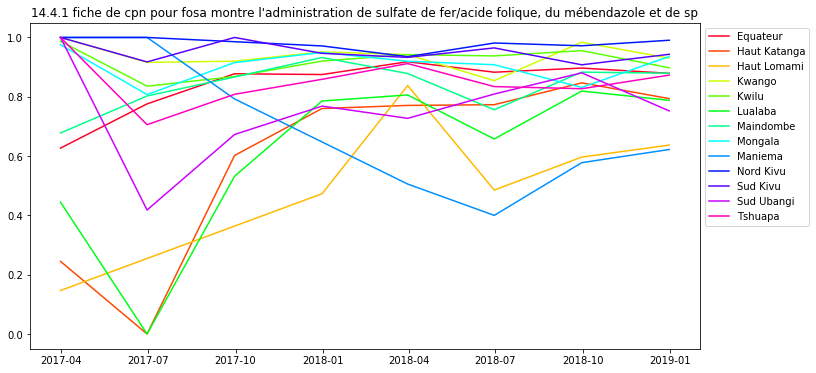

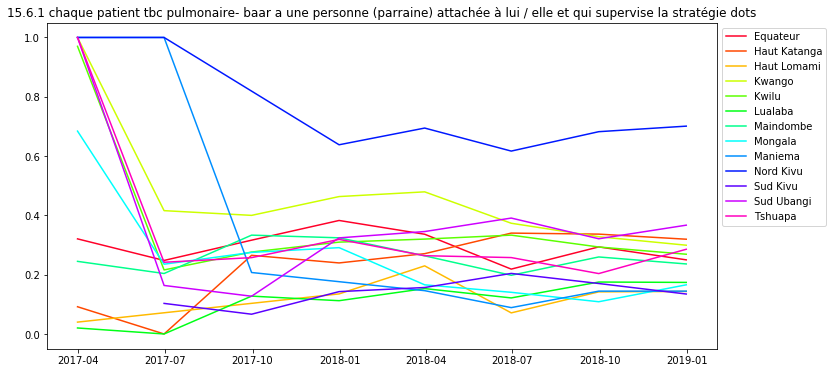

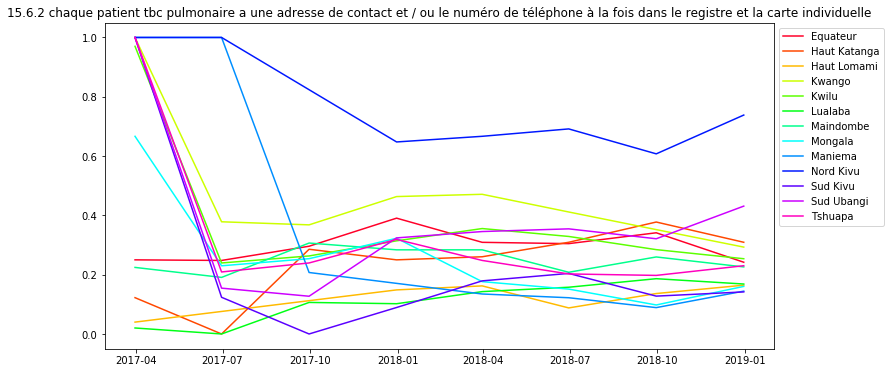

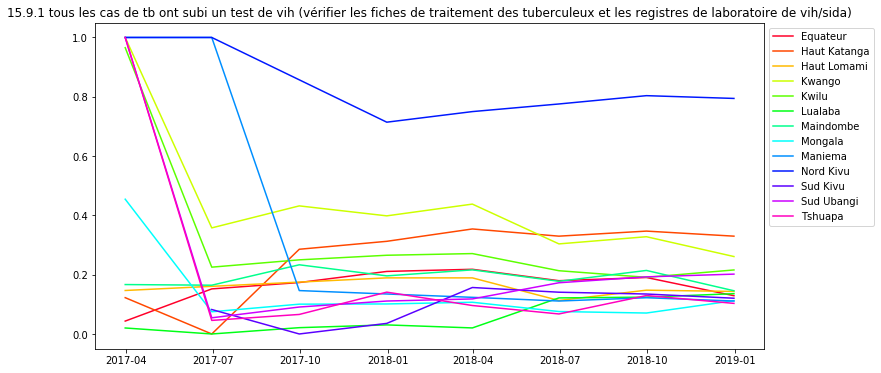

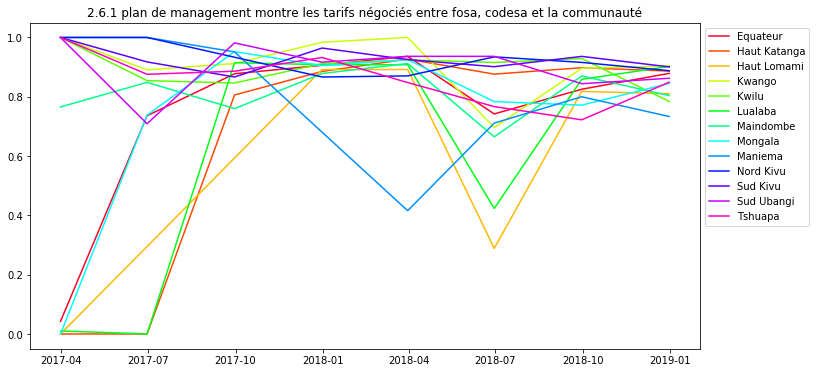

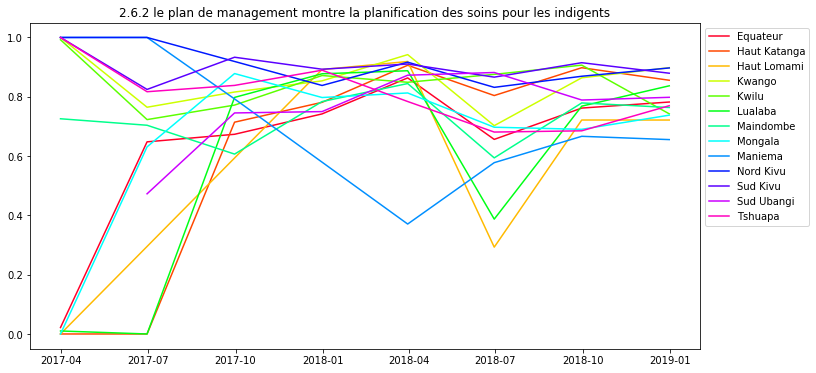

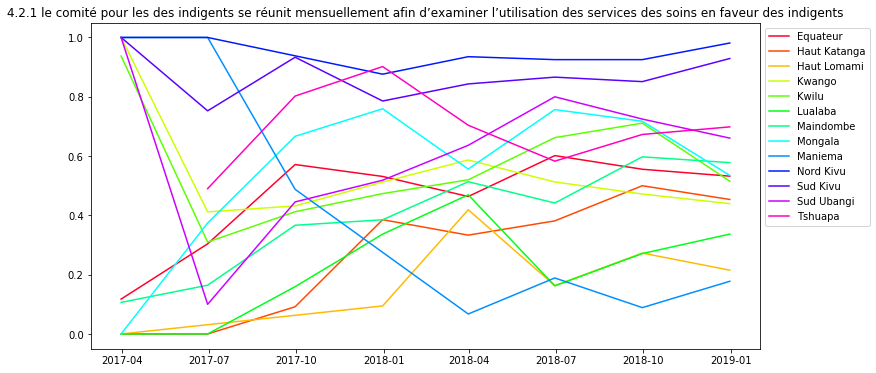

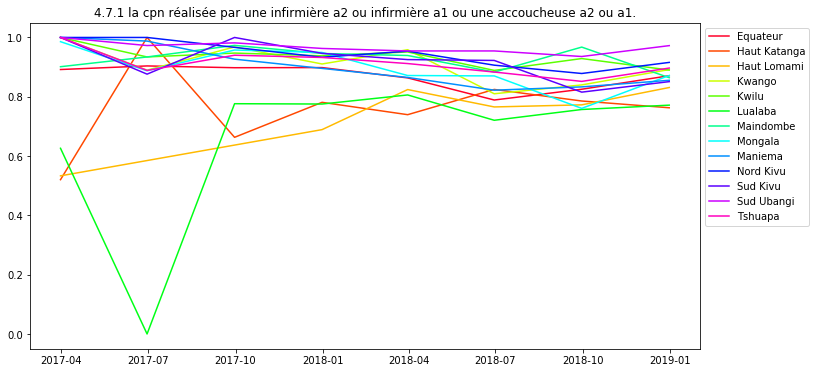

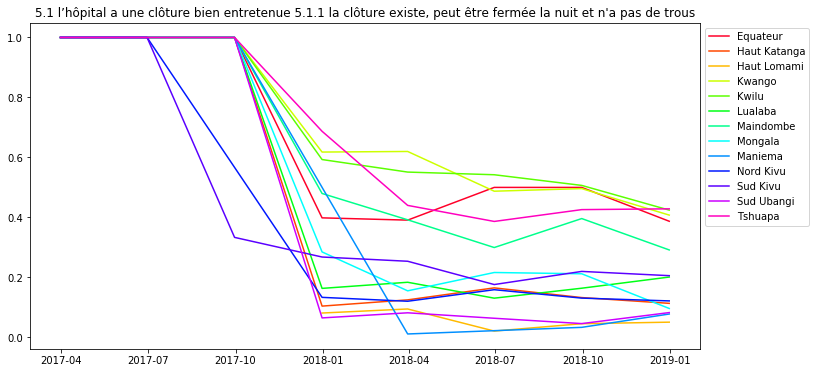

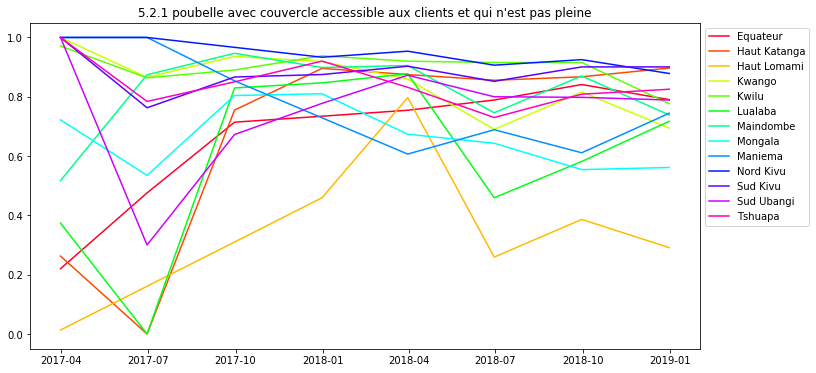

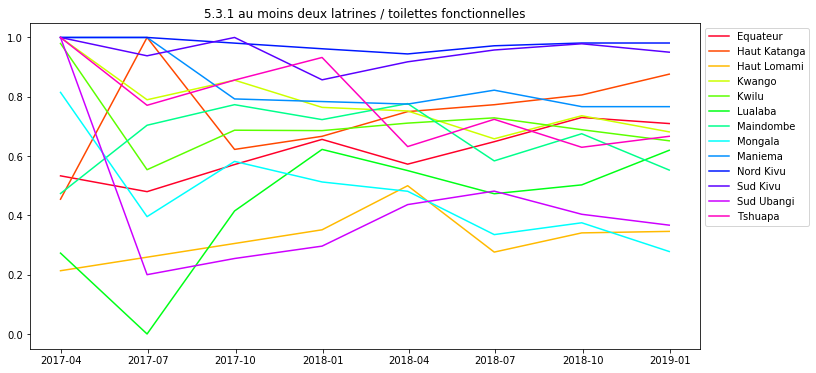

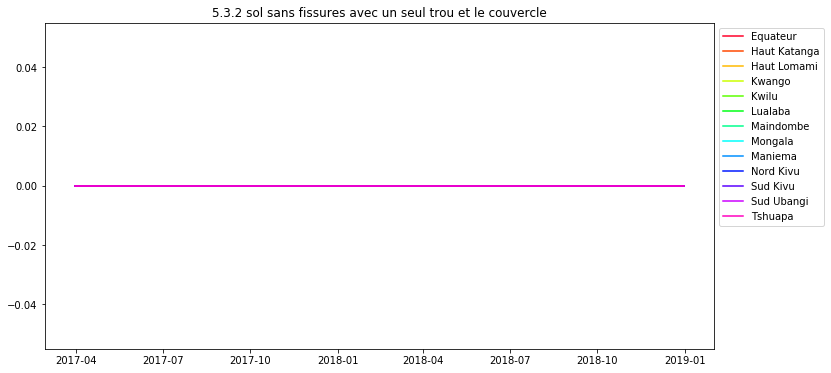

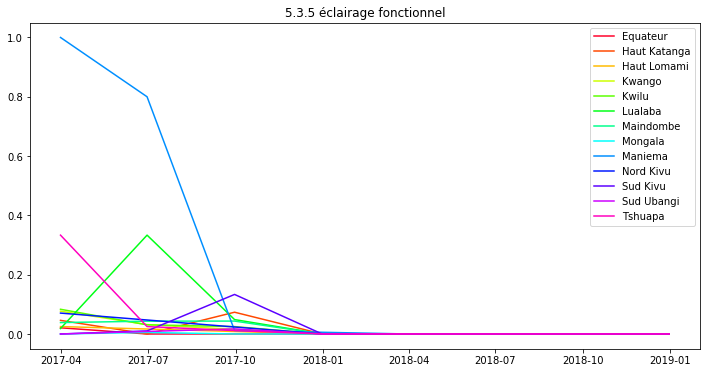

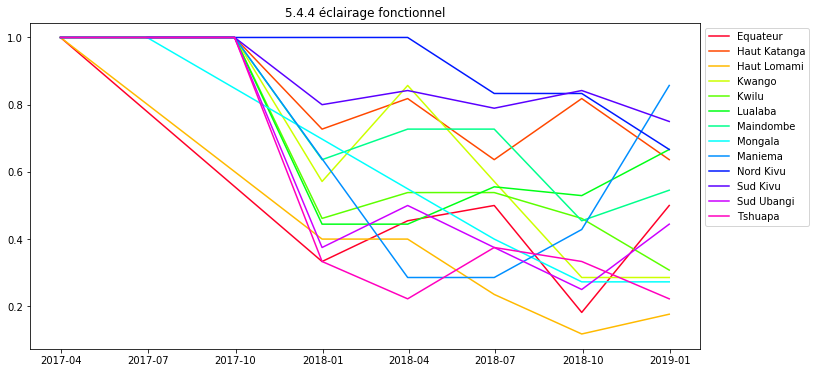

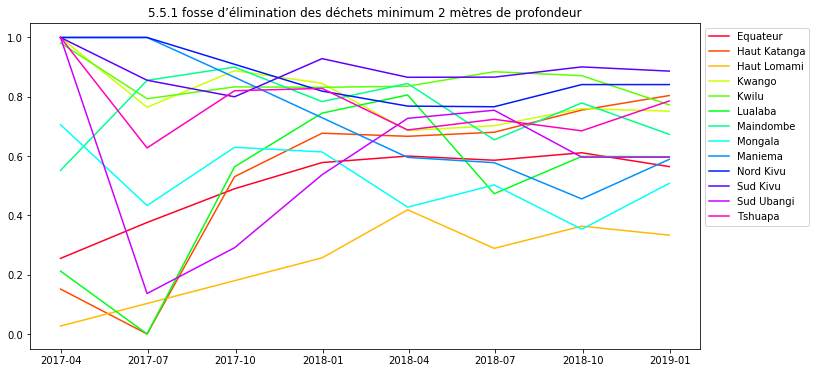

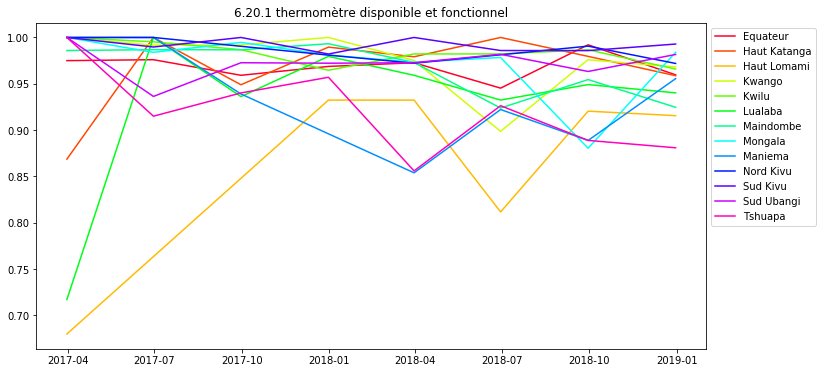

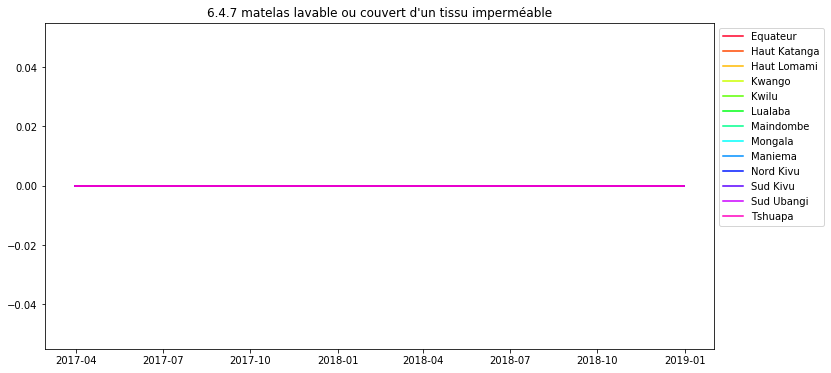

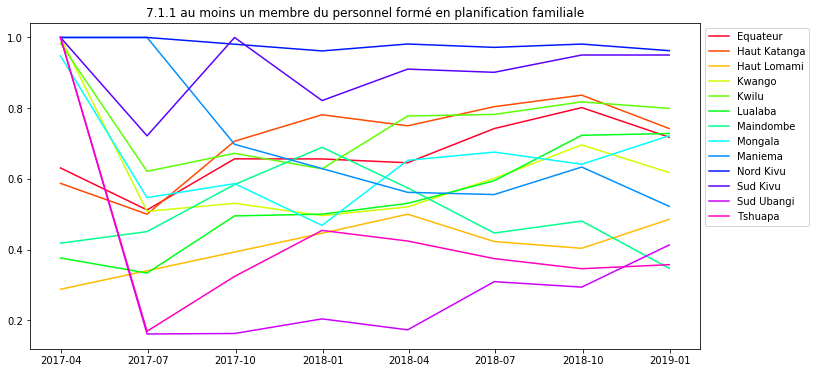

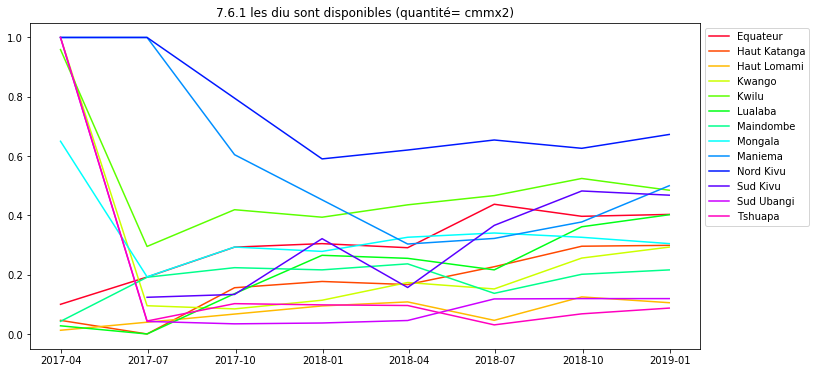

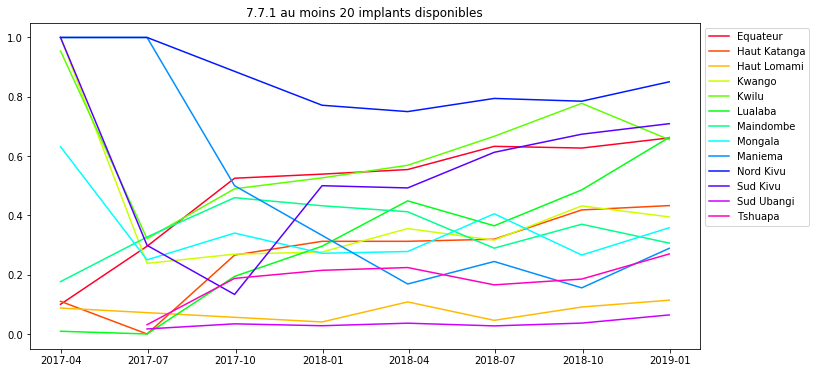

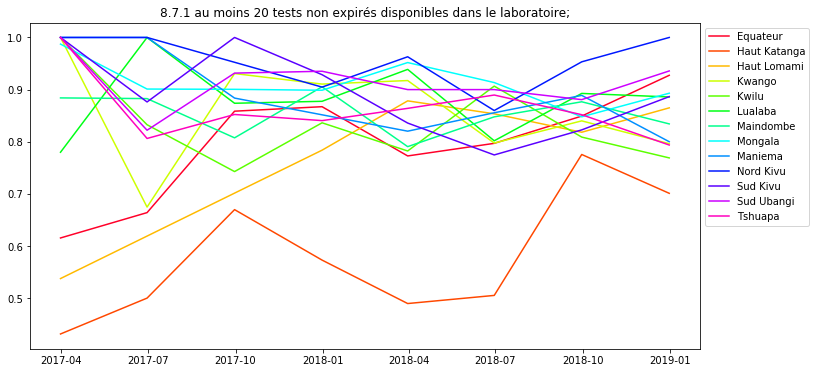

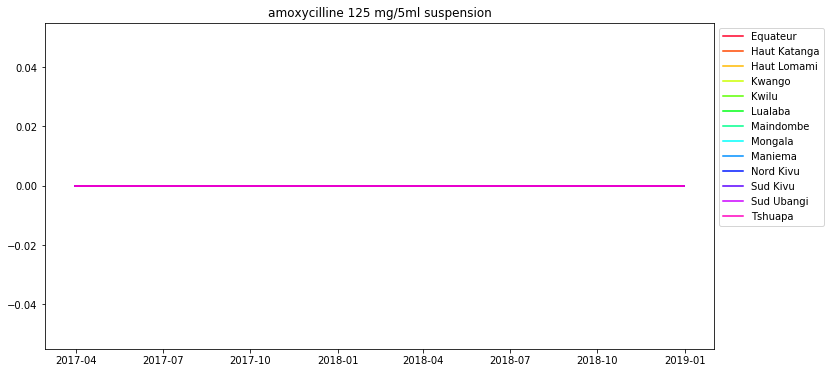

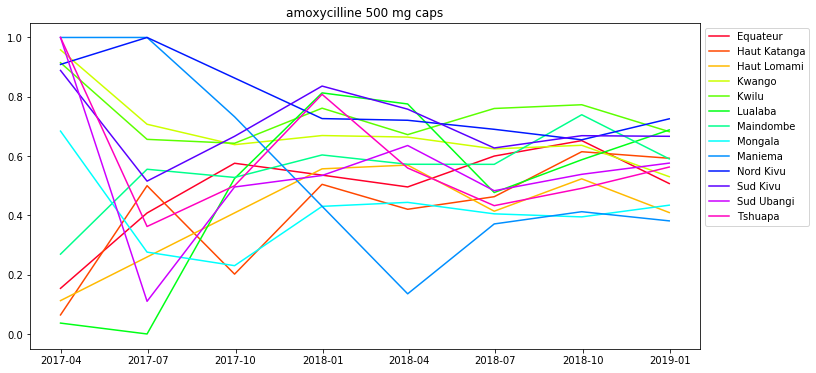

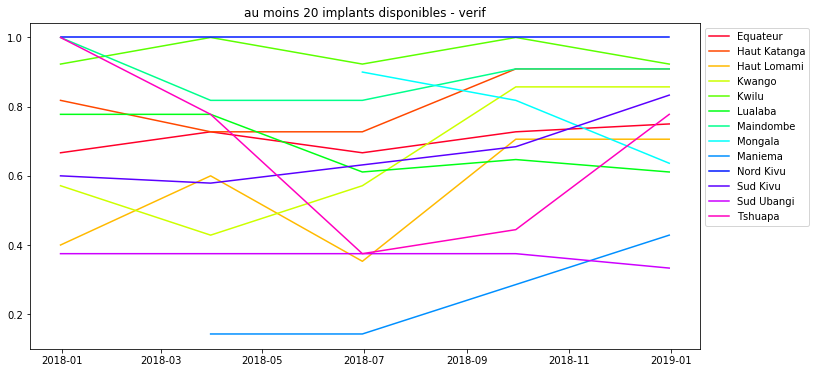

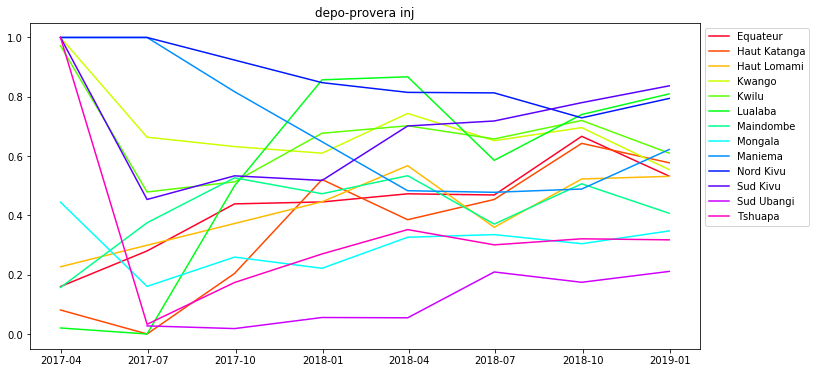

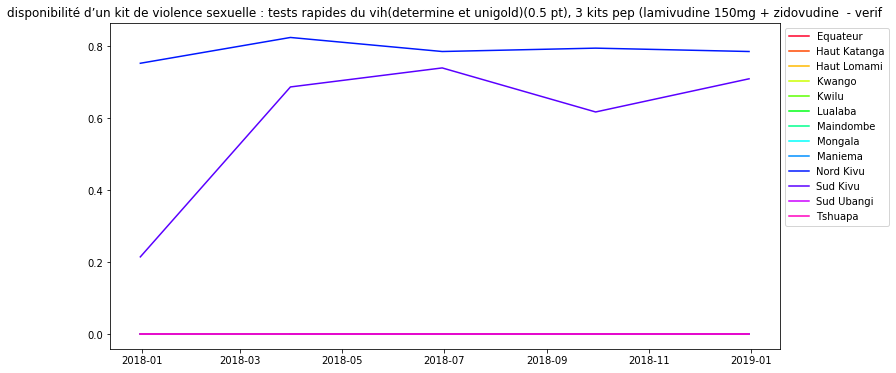

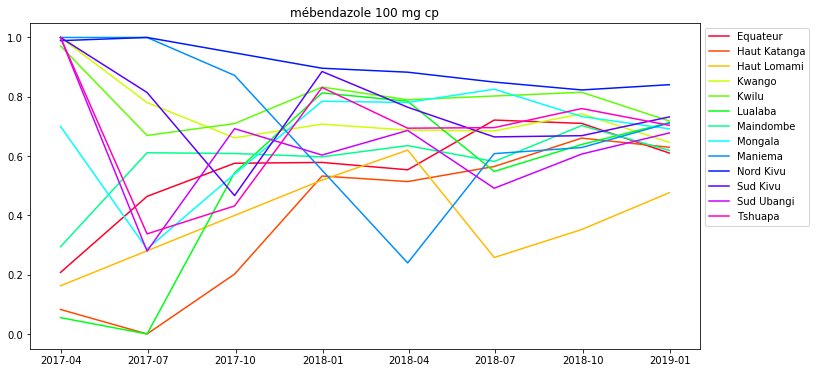

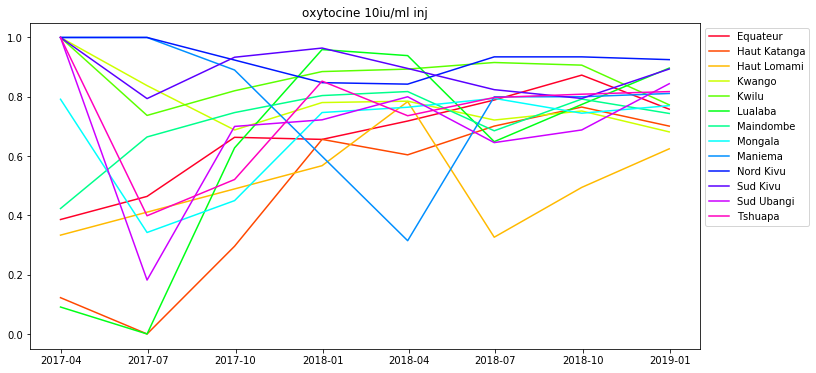

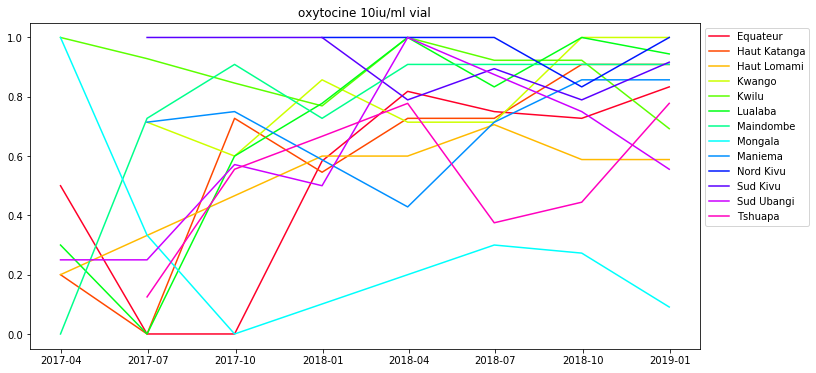

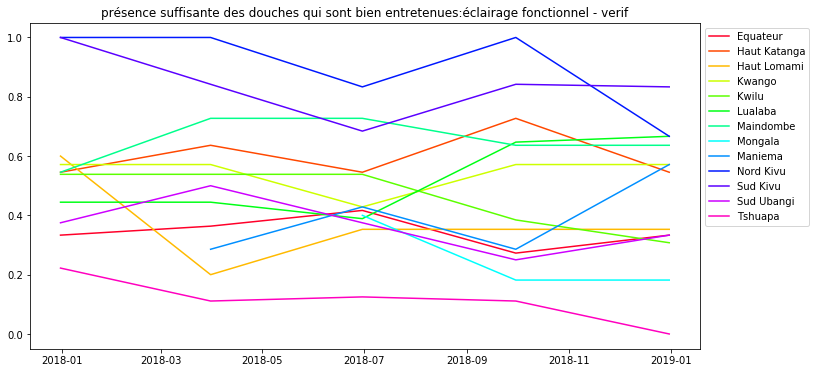

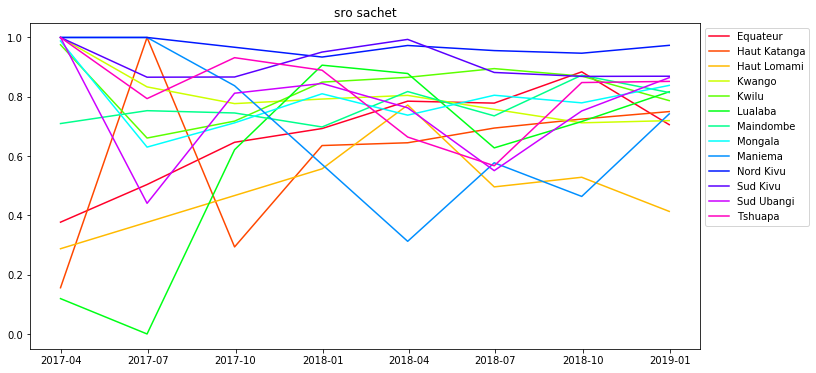

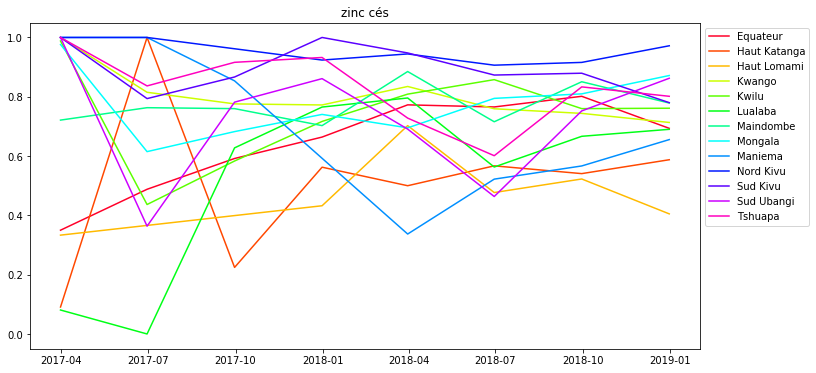

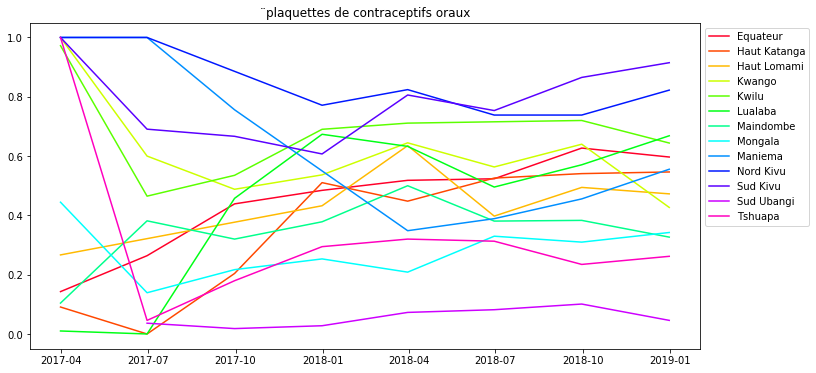

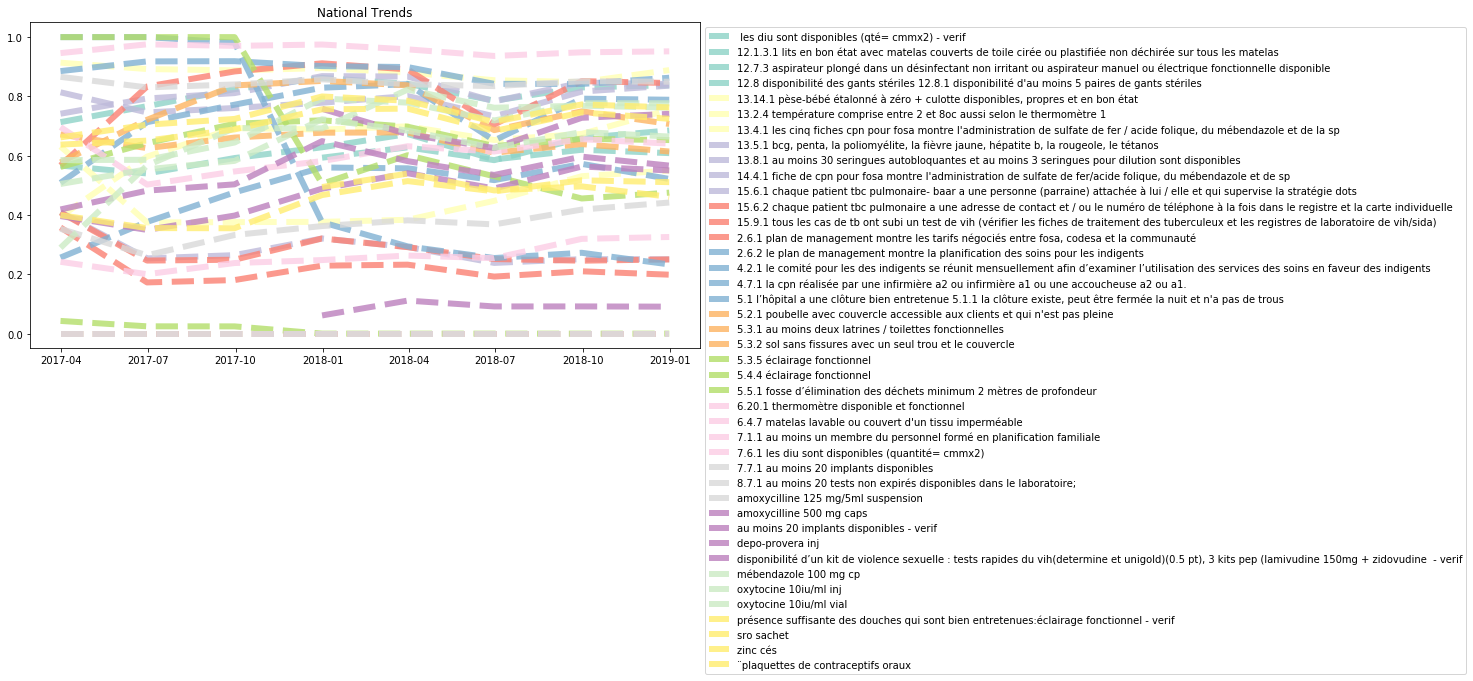

In [46]:
nat_graph = {}
for serie in sorted(pdss_extract.dataelementname.unique()):
    plot_d = pdss_extract[pdss_extract.dataelementname == serie].groupby(level=[0,3]).value.apply(lambda x: sum(x > 0) / len(x)).reset_index()
    plot_d = plot_d.merge(pdss.organisationunit[["uid","name"]], left_on ="uidlevel2" , right_on = "uid")
    cmap = plt.cm.gist_rainbow(np.linspace(0, 1, plot_d.name.nunique()))
    fig1 = plt.figure(figsize = [12,6])
    plot_d.enddate = pd.to_datetime(plot_d.enddate.astype(str),  format='%Y-%m-%d')
    i = 0
    for zone in sorted(plot_d.name.unique()):
        d = plot_d[plot_d.name == zone]
        plt.plot(d.enddate, d.value, "-", label=zone.strip()[3:-4], c = cmap[i])
        i = i+1
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title(serie)
    plot_nat = pdss_extract[pdss_extract.dataelementname == serie].groupby(level=3).value.apply(lambda x: sum(x > 0) / len(x)).reset_index()
    plot_nat.enddate = pd.to_datetime(plot_nat.enddate.astype(str),  format='%Y-%m-%d')
    nat_graph[serie] = plot_nat

fig1 = plt.figure(figsize = [12,6])
cmap = plt.cm.Set3(np.linspace(0, 1,  len(nat_graph.keys())))
i = 0
for serie in nat_graph.keys():
    plot_nat_graph = nat_graph[serie]
    plt.plot(plot_nat_graph.enddate, plot_nat_graph.value,"--", label = serie, linewidth = 6, alpha = .8, c = cmap[i])
    i = i + 1
    plt.legend(bbox_to_anchor=(1, 1)) 
    plt.title("National Trends")